In [1]:
# import required libraries
import os, glob, functools, fnmatch
from zipfile import ZipFile
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)



In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

import rasterio
from rasterio import features, mask, windows

import geopandas as gpd



In [3]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, f1_score


In [16]:
# set variables for sentinel 2 timstamps and local coordinate reference system
root_dir = r"C:\Users\91962\Desktop\zindi"
personal_dir=r"C:\Users\91962\Desktop\zindi\opp"
sentinel_timestamps = ['2017-01-01','2017-03-22', '2017-05-31', '2017-06-20', '2017-08-04']
test_sentinel_timestamp = ['2017-07-10']
target_crs = 'epsg:32734'

In [17]:
# Read the classes
class_index = pd.read_csv(os.path.join(root_dir, 'crop_id_list.csv'))
class_names = class_index.crop.unique()
print(class_index) 

   crop_id                            crop
0        1                          Cotton
1        2                           Dates
2        3                           Grass
3        4                          Lucern
4        5                           Maize
5        6                           Pecan
6        7                          Vacant
7        8                        Vineyard
8        9  Vineyard & Pecan ("Intercrop")


In [18]:
def sentinel_read(sentinel_timestamp):
    sentinel_dir = os.path.join(root_dir,sentinel_timestamp)
    bands = glob.glob(sentinel_dir+'/**/*.jp2',recursive=True)

    # Read band metadata and arrays
    # metadata
    src_2 = rasterio.open(fnmatch.filter(bands, '*B02.jp2')[0]) #blue
    src_3 = rasterio.open(fnmatch.filter(bands, '*B03.jp2')[0]) #green
    src_4 = rasterio.open(fnmatch.filter(bands, '*B04.jp2')[0]) #red
    src_8 = rasterio.open(fnmatch.filter(bands, '*B08.jp2')[0]) #near infrared

    # array
    arr_2 = src_2.read()
    arr_3 = src_3.read()
    arr_4 = src_4.read()
    arr_8 = src_8.read()
    return sentinel_dir, arr_2, arr_3, arr_4, arr_8, src_8

In [19]:
# calculate spectral indices and concatenate them into one 3 channel image
def indexnormstack(red, nir):
    
    def NDIcalc(nir, red): 
        ndi = (nir - red) / (nir  + red + 1e-5) 
        return ndi
    
    def WRDVIcalc(red,nir):
        a = 0.2
        wdrvi = (a * nir - red) / (a * nir + red)
        return wdrvi
    
    def SAVIcalc(red, nir):
        savi = 1.5 * (nir - red) / (nir + red + 0.5)
        return savi
    
    def norm(arr):
        arr_norm = (255*(arr - np.min(arr))/np.ptp(arr)) 
        return arr_norm
    
    ndvi = NDIcalc(nir,red) 
    
    savi = SAVIcalc(red,nir) 
    
    wdrvi = WRDVIcalc(red,nir)
    

    ndvi = ndvi.transpose(1,2,0)
    savi = savi.transpose(1,2,0)
    wdrvi = wdrvi.transpose(1,2,0)

    index_stack = np.dstack((ndvi, savi, wdrvi))
    
    return index_stack

In [20]:
def label(geo, src_8):
    geo = gpd.read_file(geo)
    # check for and remove invalid geometries
    geo = geo.loc[geo.is_valid] 
    # reproject training data into local coordinate reference system
    geo = geo.to_crs(crs={'init': target_crs})
    #convert the class identifier column to type integer
    geo['Crop_Id_Ne_int']  = geo.Crop_Id_Ne.astype(int)
    # pair the geometries and their integer class values
    shapes = ((geom,value) for geom, value in zip(geo.geometry, geo.Crop_Id_Ne_int)) 
    # get the metadata (height, width, channels, transform, CRS) to use in constructing the labeled image array
    src_8_prf = src_8.profile
    # construct a blank array from the metadata and burn the labels in
    labels = features.rasterize(shapes=shapes, out_shape=(src_8_prf['height'], src_8_prf['width']), fill=0, all_touched=True, transform=src_8_prf['transform'], dtype=src_8_prf['dtype'])
    print("Values in labeled image: ", np.unique(labels))
    return labels

In [48]:
"""
Optional write of the spectral index image and labels image to file. 
We have saved the files you need to the shared drive already because 
the process of writing the files for all of the Sentinel 2 scenes takes
about 2 hours. You will need to execute use this function if you are 
working from your personal drive.
"""

def save_images(sentinel_dir, index_stack, labels, src_8):
    index_stack = (index_stack * 255).astype(np.uint8)
    index_stack_t = index_stack.transpose(2,0,1)
    labels = labels.astype(np.uint8)

    index_stack_out=rasterio.open(sentinel_dir+'/index_stack.tiff', 'w', driver='Gtiff',
                              width=src_8.width, height=src_8.height,
                              count=3,
                              crs=src_8.crs,
                              transform=src_8.transform,
                              dtype='uint8')

    index_stack_out.write(index_stack_t)
    index_stack_out.close()

    labels_out=rasterio.open(sentinel_dir+'/labels.tiff', 'w', driver='Gtiff',
                              width=src_8.width, height=src_8.height,
                              count=1,
                              crs=src_8.crs,
                              transform=src_8.transform,
                              dtype='uint8')

    labels_out.write(labels, 1)
    labels_out.close()
    
    return sentinel_dir+'/index_stack.tiff', sentinel_dir+'/labels.tiff'

In [49]:
def tile(index_stack, labels, sentinel_timestamp):
    tiles_dir = root_dir+'tiled/'
    img_dir = root_dir+'tiled/images/'
    label_dir = root_dir+'tiled/labels/'
    dirs = [tiles_dir, img_dir, label_dir]
    for d in dirs:
        if not os.path.exists(d):
            os.makedirs(d)
    
    # set tile height and width
    height,width = 224, 224
    
    def get_tiles(ds, width=224, height=224):
        # get number of rows and columns (pixels) in the entire input image
        nols, nrows = ds.meta['width'], ds.meta['height']
        # get the grid from which tiles will be made 
        offsets = product(range(0, nols, width), range(0, nrows, height))
        # get the window of the entire input image
        big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
        # tile the big window by mini-windows per grid cell
        for col_off, row_off in offsets:
            window = windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
            transform = windows.transform(window, ds.transform)
            yield window, transform
      
    tile_width, tile_height = 224, 224
    
    def crop(inpath, outpath, c):
        # read input image
        image = rasterio.open(inpath)
        # get the metadata 
        meta = image.meta.copy()
        # set the number of channels to 3 or 1, depending on if its the index image or labels image
        meta['count'] = int(c)
        # set the tile output file format to PNG (saves spatial metadata unlike JPG)
        meta['driver']='PNG'
        # tile the input image by the mini-windows
        i = 0
        for window, transform in get_tiles(image):
            meta['transform'] = transform
            meta['width'], meta['height'] = window.width, window.height
            outfile = outpath+"tile_%s_%s.png" % (sentinel_timestamp, str(i))
            with rasterio.open(outfile, 'w', **meta) as outds:
                outds.write(image.read(window=window))
            i = i+1
            
    def process_tiles(index_flag):
        # tile the input images, when index_flag == True, we are tiling the spectral index image, 
        # when False we are tiling the labels image
        if index_flag==True:
            inpath = sentinel_dir+'/index_stack.tiff'
            outpath=img_dir
            crop(inpath, outpath, 3)
        else:
            inpath = sentinel_dir+'/labels.tiff'
            outpath=label_dir
            crop(inpath, outpath, 1)
                
    process_tiles(index_flag=True) # tile index stack
    process_tiles(index_flag=False) # tile labels
    return tiles_dir, img_dir, label_dir

In [33]:
# If you want to write the files out to your personal drive, set write_out = True, but I recommend trying 
# that in your free time because it takes about 2 hours for all 4 training Sentinel timetamps, 
# and about 30 minutes for the test timestamp.

write_out = True
if write_out == True:
  for timestamp in [test_sentinel_timestamp[0]]:
    #timestamp, tiles_dir, img_dir, label_dir = main(timestamp)
    print("timestamp: ", timestamp)

    sentinel_dir, arr_2, arr_3, arr_4, arr_8, src_8 = sentinel_read(timestamp)

    # Calculate indices and combine the indices into one single 3 channel image

    index_stack = indexnormstack(arr_4, arr_8)

    # Rasterize labels
    labels = label(r"C:\Users\91962\Desktop\zindi\train\train\train.shp", src_8)

    # reset the path of the Sentinel 2 image directory to your personal drive if you want to write the
    # files out
    
    sentinel_dir = os.path.join(r"C:\Users\91962\Desktop\zindi\opp",timestamp)
    if not os.path.exists(sentinel_dir):
      os.makedirs(sentinel_dir)
    print(sentinel_dir, src_8)

    # Save index stack and labels to geotiff
    index_stack_file, labels_file = save_images(sentinel_dir, index_stack, labels, src_8)

    # Tile images into 224x224
    tiles_dir, img_dir, label_dir = tile(index_stack, labels, timestamp)
else:
  print("Not writing to file; using data in shared drive.")

timestamp:  2017-07-10


c:\Users\91962\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Values in labeled image:  [0 1 2 3 4 5 6 7 8 9]
C:\Users\91962\Desktop\zindi\opp\2017-07-10 <open DatasetReader name='C:/Users/91962/Desktop/zindi/2017-07-10/S2A_MSIL1C_20170710T082011_N0205_R121_T34JEP_20170710T084244.SAFE/GRANULE/L1C_T34JEP_A010700_20170710T084244/IMG_DATA/T34JEP_20170710T082011_B08.jp2' mode='r'>


In [79]:
# set the paths to point to the tiles images
tiles_dir = root_dir+'tiled/'

# train
img_dir = root_dir+'tiled/images/'
label_dir = root_dir+'tiled/labels_test/'

# test
test_img_dir = root_dir+'tiled/images_test/'
test_label_dir = root_dir+'tiled/labels_test/'

In [81]:
import os

# Function to count files in a directory
def count_files(directory):
    file_list = os.listdir(directory)
    return len(file_list)

# Replace '/path/to/your/image/directory' with the actual path to your image directory
image_test_dir = root_dir+'tiled/images/'


# Count files in the image directory
num_files = count_files(r"C:\Users\91962\Desktop\zinditiled\images_test")
print("Number of files in the directory:", num_files)

# Replace '$test_img_dir' with the variable representing the path to your test image directory
# If '$test_img_dir' is a Python variable, replace it with its actual value
# For example:
# test_img_dir = '/path/to/your/test/image/directory'
# num_test_files = count_files(test_img_dir)
# print("Number of files in the test image directory:", num_test_files)


Number of files in the directory: 5000


In [82]:
import os
img_dir = root_dir+'tiled/images/'
image_test_dir = root_dir+'tiled/images_test/'

# Count files in img_dir
num_files_img_dir = len(os.listdir(img_dir))

# Count files in test_img_dir
num_files_test_img_dir = len(os.listdir(test_img_dir))

print("Number of files in img_dir:", num_files_img_dir)
print("Number of files in test_img_dir:", num_files_test_img_dir)


Number of files in img_dir: 5000
Number of files in test_img_dir: 5000


In [83]:
import os

# List files in the img_dir directory
img_files = os.listdir(img_dir)
num_img_files = len(img_files)
print("Number of images in img_dir:", num_img_files)

# List files in the test_img_dir directory
test_img_files = os.listdir(test_img_dir)
num_test_img_files = len(test_img_files)
print("Number of images in test_img_dir:", num_test_img_files)


Number of images in img_dir: 5000
Number of images in test_img_dir: 5000


In [84]:
# get lists of image and label tile pairs for training and testing

def get_train_test_lists(imdir, lbldir):
  imgs = glob.glob(imdir+"/*.png")
  dset_list = []
  for img in imgs:
    filename_split = os.path.splitext(img) 
    filename_zero, fileext = filename_split 
    basename = os.path.basename(filename_zero) 
    dset_list.append(basename)
    
  x_filenames = []
  y_filenames = []
  for img_id in dset_list:
    x_filenames.append(os.path.join(imdir, "{}.png".format(img_id)))
    y_filenames.append(os.path.join(lbldir, "{}.png".format(img_id)))
    
  print("number of images: ", len(dset_list))
  return dset_list, x_filenames, y_filenames

In [59]:
train_list, x_train_filenames, y_train_filenames = get_train_test_lists(img_dir, label_dir)

number of images:  2500


In [85]:
test_list, x_test_filenames, y_test_filenames = get_train_test_lists(test_img_dir, test_label_dir)

number of images:  2500


In [86]:
skip = False
if not skip:
  background_list_train = []
  for i in train_list: 
      # read in each labeled images
      img = np.array(Image.open(label_dir+"{}.png".format(i))) 
      # check if no values in image are greater than zero (background value)
      if img.max()==0:
          background_list_train.append(i)
          
  print("number of background training images: ", len(background_list_train))

  background_list_test = []
  for i in test_list: 
      img = np.array(Image.open(test_label_dir+"{}.png".format(i))) 
      if img.max()==0:
          background_list_test.append(i)
          
  print("number of background test images: ", len(background_list_test))

  with open(os.path.join(personal_dir,'background_list_train.txt'), 'w') as f:
    for item in background_list_train:
        f.write("%s\n" % item)
  with open(os.path.join(personal_dir,'background_list_test.txt'), 'w') as f:
    for item in background_list_test:
        f.write("%s\n" % item)

else:
  background_list_train = [line.strip() for line in open("background_list_train.txt", 'r')]
  print("number of background training images: ", len(background_list_train))
  
  background_list_test = [line.strip() for line in open("background_list_test.txt", 'r')]
  print("number of background test images: ", len(background_list_test))

number of background training images:  2405
number of background test images:  2405


In [87]:
background_removal = len(background_list_train) * 0.9
train_list_clean = [y for y in train_list if y not in background_list_train[0:int(background_removal)]]

x_train_filenames = []
y_train_filenames = []
for img_id in train_list_clean: 
  x_train_filenames.append(os.path.join(img_dir, "{}.png".format(img_id)))
  y_train_filenames.append(os.path.join(label_dir, "{}.png".format(img_id)))
    
print(len(train_list_clean))

336


In [88]:
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = train_test_split(x_train_filenames, y_train_filenames, test_size=0.1, random_state=42)

num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 302
Number of validation examples: 34
Number of test examples: 2500


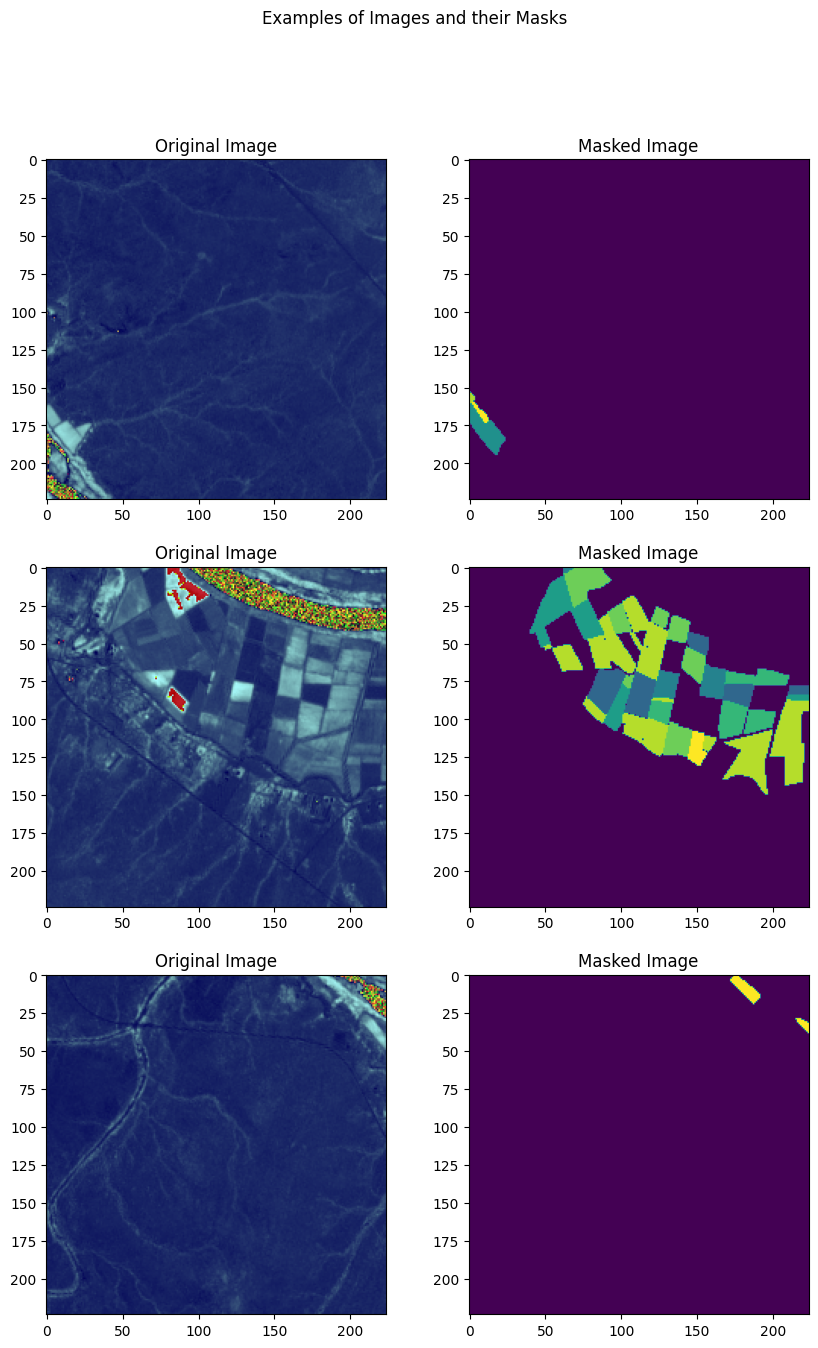

In [89]:
display_num = 3

# select only for tiles with foreground labels present
foreground_list_x = []
foreground_list_y = []
for x,y in zip(x_train_filenames, y_train_filenames): 
    img = np.array(Image.open(y)) 
    if img.max()>0:
        foreground_list_x.append(x)
        foreground_list_y.append(y)

num_foreground_examples = len(foreground_list_y)

# randomlize the choice of image and label pairs
r_choices = np.random.choice(num_foreground_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = foreground_list_x[img_num]
  y_pathname = foreground_list_y[img_num]
  
  plt.subplot(display_num, 2, i + 1)
  plt.imshow(mpimg.imread(x_pathname))
  plt.title("Original Image")
  
  example_labels = Image.open(y_pathname)
  label_vals = np.unique(np.array(example_labels))
  
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(example_labels)
  plt.title("Masked Image")  
  
plt.suptitle("Examples of Images and their Masks")
plt.show()

In [90]:
#Read the tiles into tensors
# set input image shape
img_shape = (224, 224, 3)
# set batch size for model
batch_size = 2

In [91]:
# Function for reading the tiles into TensorFlow tensors 
# See TensorFlow documentation for explanation of tensor: https://www.tensorflow.org/guide/tensor
def _process_pathnames(fname, label_path):
  # We map this function onto each pathname pair  
  img_str = tf.io.read_file(fname)
  img = tf.image.decode_png(img_str, channels=3)

  label_img_str = tf.io.read_file(label_path)

  # These are png images so they return as (num_frames, h, w, c)
  label_img = tf.image.decode_png(label_img_str, channels=1)
  # The label image should have any values between 0 and 9, indicating pixel wise
  # cropt type class or background (0). We take the first channel only. 
  label_img = label_img[:, :, 0]
  label_img = tf.expand_dims(label_img, axis=-1)
  return img, label_img

In [92]:
# Function to augment the data with horizontal flip
def flip_img_h(horizontal_flip, tr_img, label_img):
  if horizontal_flip:
    flip_prob = tf.random.uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

In [93]:
# Function to augment the data with vertical flip
def flip_img_v(vertical_flip, tr_img, label_img):
  if vertical_flip:
    flip_prob = tf.random.uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_up_down(tr_img), tf.image.flip_up_down(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

In [94]:
# Function to augment the images and labels
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             horizontal_flip=False,
             vertical_flip=False): 
  if resize is not None:
    # Resize both images
    label_img = tf.image.resize(label_img, resize)
    img = tf.image.resize(img, resize)
  
  img, label_img = flip_img_h(horizontal_flip, img, label_img)
  img, label_img = flip_img_v(vertical_flip, img, label_img)
  img = tf.cast(img, tf.float32) * scale  #tf.to_float(img) * scale 
  #label_img = tf.cast(label_img, tf.float32) * scale
  #print("tensor: ", tf.unique(tf.keras.backend.print_tensor(label_img)))
  return img, label_img

In [95]:
# Main function to tie all of the above four dataset processing functions together 
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True):           
  num_x = len(filenames)
  # Create a dataset from the filenames and labels
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  # Map our preprocessing function to every element in our dataset, taking
  # advantage of multithreading
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
    assert batch_size == 1, "Batching images must be of the same size"

  dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
  
  if shuffle:
    dataset = dataset.shuffle(num_x)
  
  
  # It's necessary to repeat our data for all epochs 
  dataset = dataset.repeat().batch(batch_size)
  return dataset

In [96]:
# dataset configuration for training
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'horizontal_flip': True,
    'vertical_flip': True,
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [97]:
# dataset configuration for validation
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

In [98]:
# dataset configuration for testing
test_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
test_preprocessing_fn = functools.partial(_augment, **test_cfg)

In [99]:
# create the TensorFlow datasets
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)
test_ds = get_baseline_dataset(x_test_filenames,
                              y_test_filenames, 
                              preproc_fn=test_preprocessing_fn,
                              batch_size=batch_size)

In [100]:
# Now we will display some samples from the datasets
display_num = 1
r_choices = np.random.choice(num_foreground_examples, 1)
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]

temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1], 
                               foreground_list_y[img_num:img_num+1],
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)

# Let's examine some of these augmented images

iterator = iter(temp_ds)
next_element = iterator.get_next()

batch_of_imgs, label = next_element

# Running next element in our graph will produce a batch of images

sample_image, sample_mask = batch_of_imgs[0], label[0,:,:,:]

In [101]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

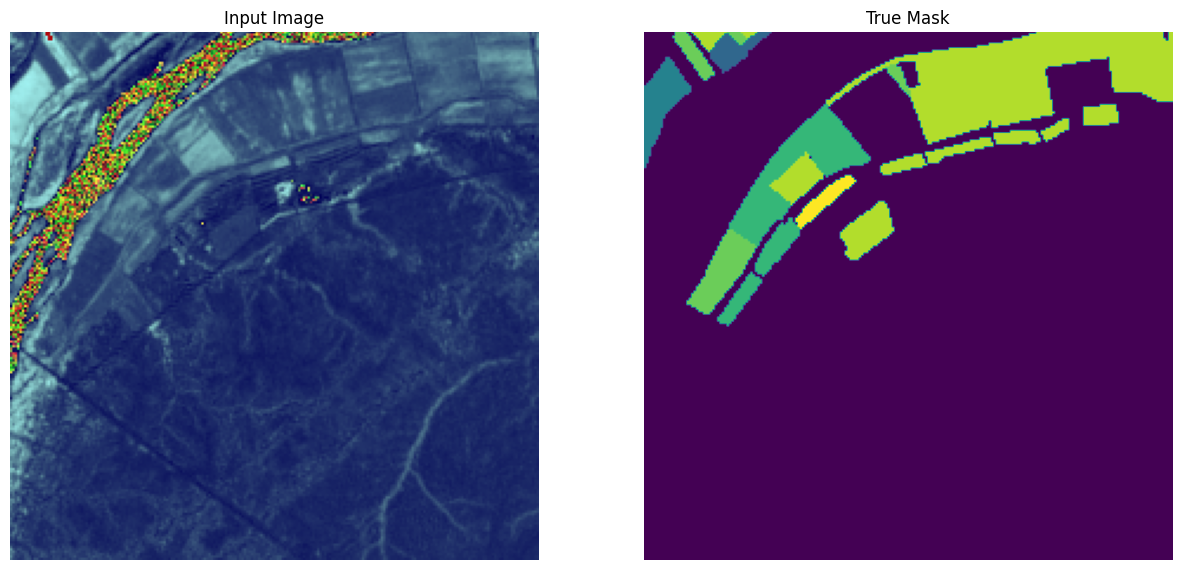

In [82]:
# display sample train image
display([sample_image, sample_mask])

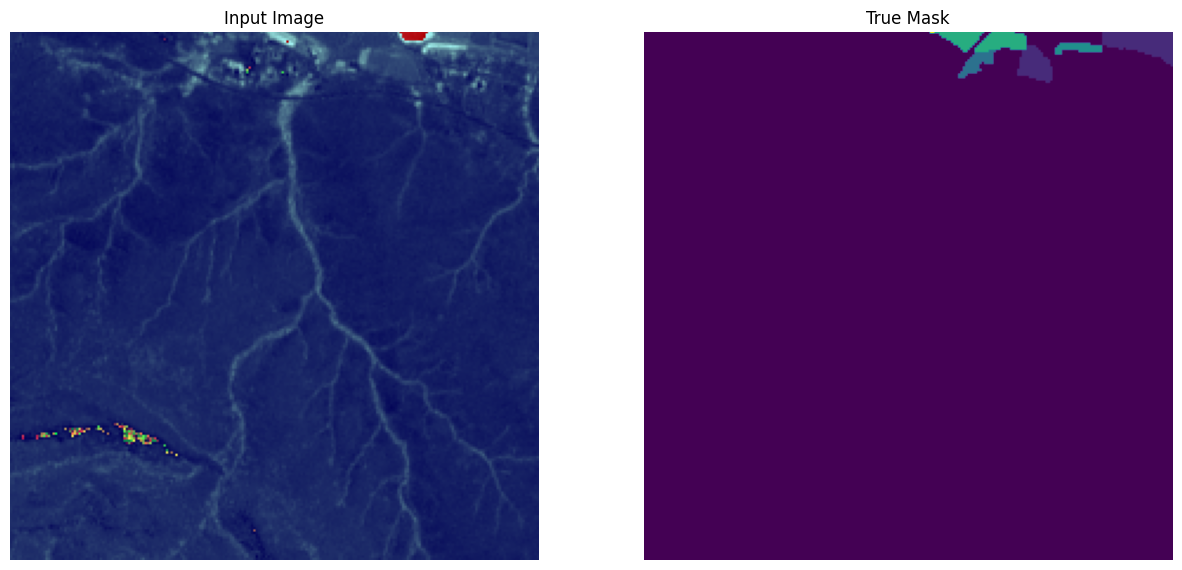

In [102]:
# reset the forground list to capture the validation images
foreground_list_x = []
foreground_list_y = []
for x,y in zip(x_val_filenames, y_val_filenames): 
    img = np.array(Image.open(y)) 
    if img.max()>0:
        foreground_list_x.append(x)
        foreground_list_y.append(y)

num_foreground_examples = len(foreground_list_y)

display_num = 1
r_choices = np.random.choice(num_foreground_examples, 1)
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]

temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1], 
                               foreground_list_y[img_num:img_num+1],
                               preproc_fn=val_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)

# Let's examine some of these augmented images

iterator = iter(temp_ds)
next_element = iterator.get_next()

batch_of_imgs, label = next_element

# Running next element in our graph will produce a batch of images

sample_image, sample_mask = batch_of_imgs[0], label[0,:,:,:]

# display sample validation image
display([sample_image, sample_mask])

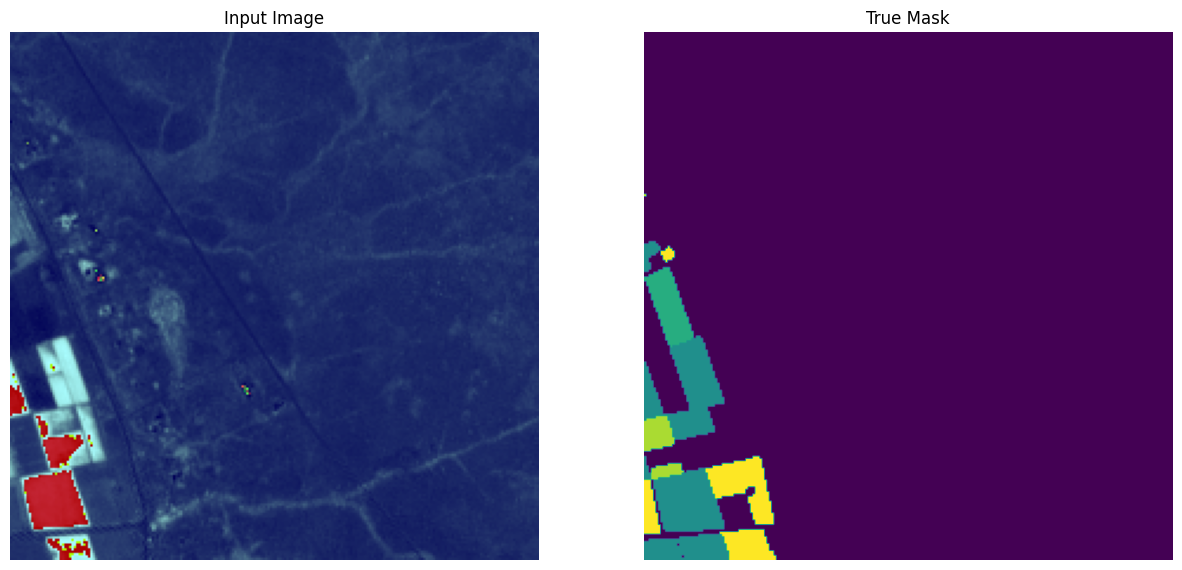

In [103]:
# reset the forground list to capture the test images
foreground_list_x = []
foreground_list_y = []
for x,y in zip(x_test_filenames, y_test_filenames): 
    img = np.array(Image.open(y)) 
    if img.max()>0:
        foreground_list_x.append(x)
        foreground_list_y.append(y)

num_foreground_examples = len(foreground_list_y)

display_num = 1
r_choices = np.random.choice(num_foreground_examples, 1)
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]

temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1], 
                               foreground_list_y[img_num:img_num+1],
                               preproc_fn=test_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)

# Let's examine some of these augmented images

iterator = iter(temp_ds)
next_element = iterator.get_next()

batch_of_imgs, label = next_element

# Running next element in our graph will produce a batch of images

sample_image, sample_mask = batch_of_imgs[0], label[0,:,:,:]

# display sample test image
display([sample_image, sample_mask])

In [104]:
# set number of model output channels to the number of classes (including background)
OUTPUT_CHANNELS = 10

In [105]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [106]:
import tensorflow as tf

# Define the upsampling layers
up_stack = [
    tf.keras.layers.UpSampling2D(size=(2, 2)),  # 4x4 -> 8x8
    tf.keras.layers.UpSampling2D(size=(2, 2)),  # 8x8 -> 16x16
    tf.keras.layers.UpSampling2D(size=(2, 2)),  # 16x16 -> 32x32
    tf.keras.layers.UpSampling2D(size=(2, 2)),  # 32x32 -> 64x64
]

In [107]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[224,224,3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 224x224

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [108]:
model = unet_model(OUTPUT_CHANNELS)

In [109]:
train_df = pd.read_csv(r"C:\Users\91962\Desktop\zindi\Farmpin_training.csv")
inv_freq = np.array(1/(train_df.crop_id.value_counts()/len(train_df)))
inv_freq = [0.,*inv_freq]
class_weights = {0 : inv_freq[0], 1: inv_freq[1], 2: inv_freq[2], 3: inv_freq[3], 
                4: inv_freq[4], 5: inv_freq[5], 6: inv_freq[6],
                7: inv_freq[7], 8: inv_freq[8], 9: inv_freq[9]}

In [110]:
class_weights

{0: 0.0,
 1: 2.647932131495228,
 2: 4.6585820895522385,
 3: 8.823321554770319,
 4: 9.352059925093632,
 5: 16.98639455782313,
 6: 17.58450704225352,
 7: 26.28421052631579,
 8: 32.42857142857143,
 9: 356.7142857142857}

In [111]:
from focal_loss import SparseCategoricalFocalLoss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=SparseCategoricalFocalLoss(gamma=2, from_logits=True),
              metrics=['accuracy'])

In [112]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [113]:
# this is preiction before training

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    mp = create_mask(model.predict(sample_image[tf.newaxis, ...]))
    mpe = tf.keras.backend.eval(mp)
    display([sample_image, sample_mask, mpe])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


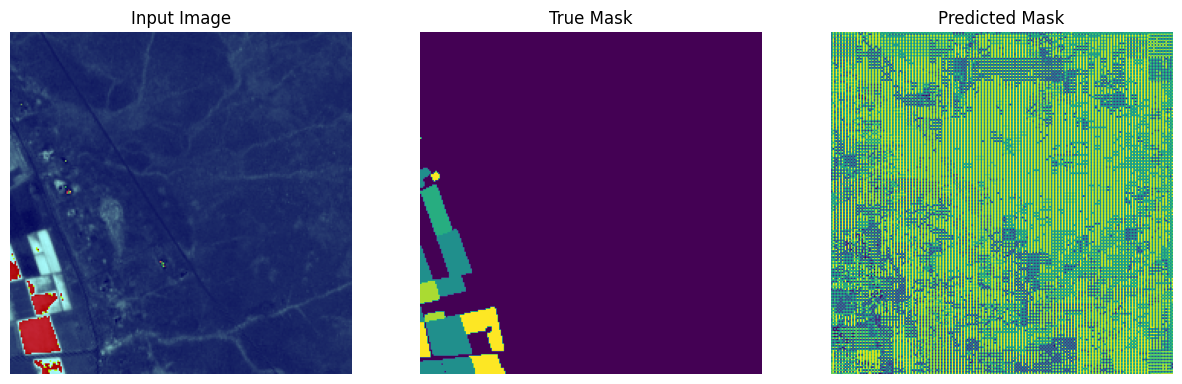

In [114]:
show_predictions()

In [115]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=False)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


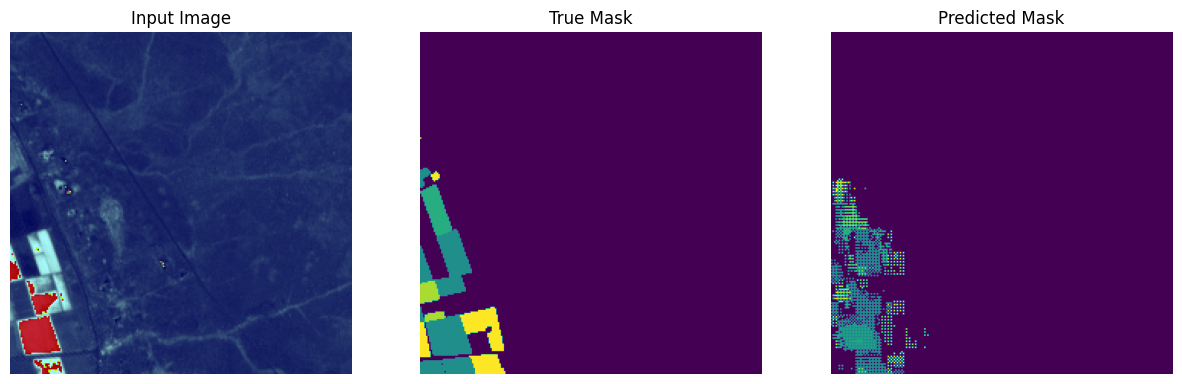


Sample Prediction after epoch 25

151/151 ━━━━━━━━━━━━━━━━━━━━ 39s 260ms/step - accuracy: 0.9714 - loss: 0.0816 - val_accuracy: 0.9476 - val_loss: 0.1901


In [116]:
'''Fit and View
Now we will actually train the model for 100 epochs (full cycles through the training dataset), 
visualizing predictions on a validation image after each epoch.
'''

EPOCHS = 25

model_history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=EPOCHS,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[DisplayCallback()]) 

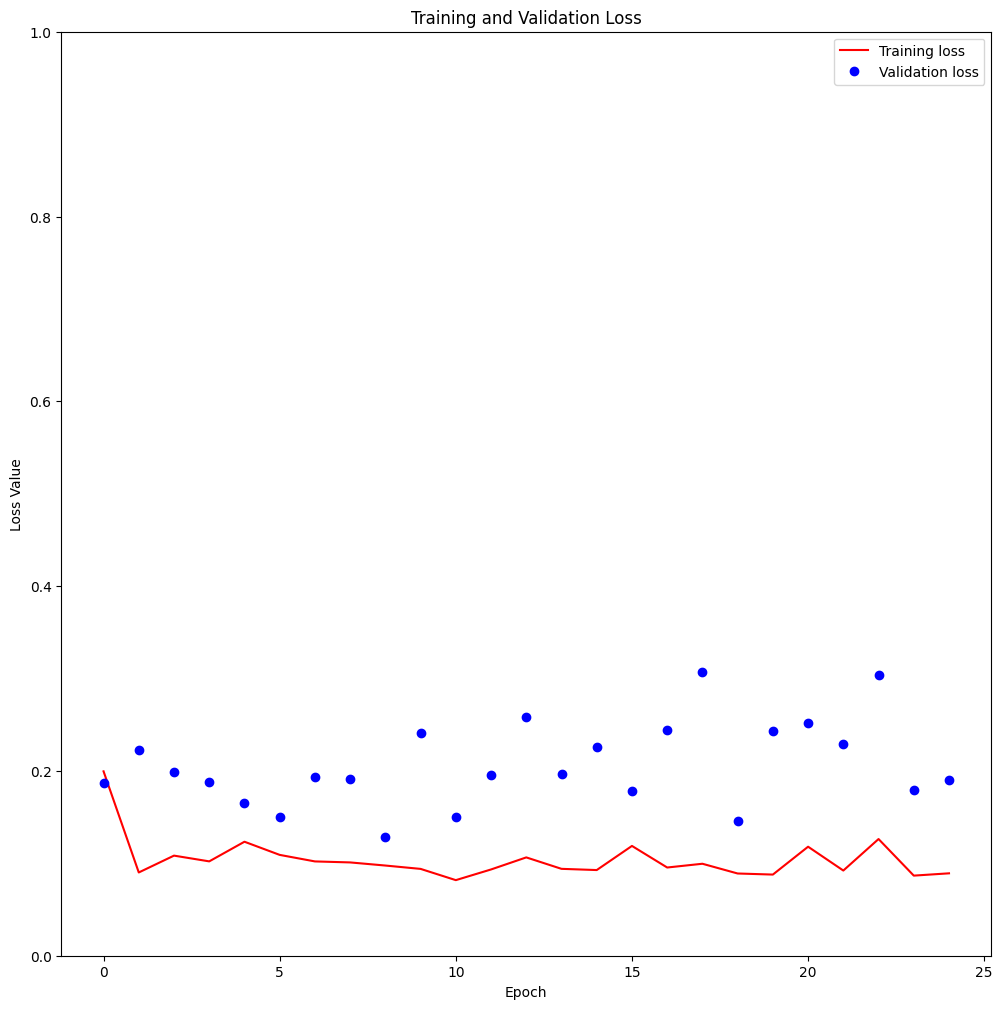

In [135]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [115]:
import os
import tensorflow
from tensorflow.keras.models import save_model



In [136]:
import os
import tensorflow as tf

# Define the filepath for saving the model
save_model_path = os.path.join(personal_dir, 'model_out/')

# Save the model to the specified filepath
tf.saved_model.save(model, save_model_path)

INFO:tensorflow:Assets written to: C:\Users\91962\Desktop\zindi\opp\model_out/assets


INFO:tensorflow:Assets written to: C:\Users\91962\Desktop\zindi\opp\model_out/assets


In [137]:
# Optional, you can load the model from the saved version
load_from_checkpoint = False
if load_from_checkpoint == True:
  model = tf.keras.models.load_model(save_model_path)
else:
  print("inferencing from in memory model")

inferencing from in memory model


In [119]:
def get_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      return pred_mask
  else:
    pred_mask = create_mask(model.predict(sample_image[tf.newaxis, ...]))
    pred_mask = tf.keras.backend.eval(pred_mask)
    return pred_mask

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


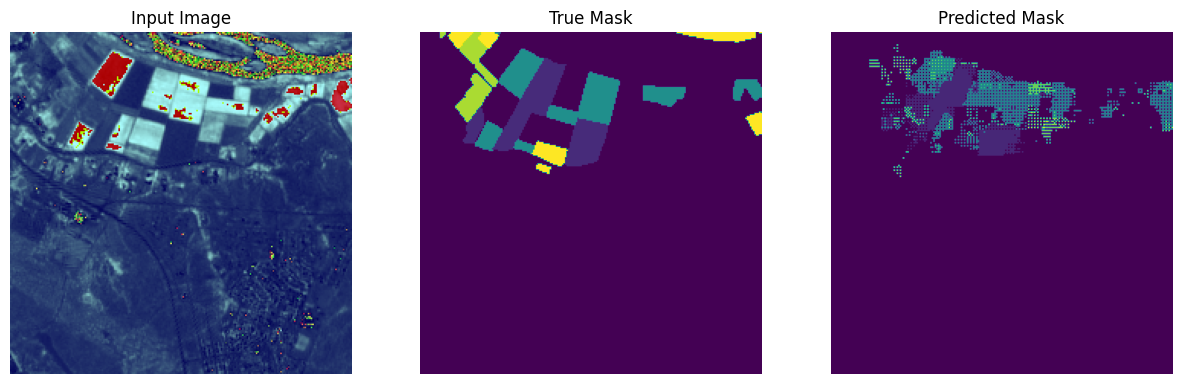

In [120]:
#Single image example
display_num = 1
r_choices = np.random.choice(num_foreground_examples, 1)
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]

temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1], 
                               foreground_list_y[img_num:img_num+1],
                               preproc_fn=test_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)

# Let's examine some of these augmented images

iterator = iter(temp_ds)
next_element = iterator.get_next()

batch_of_imgs, label = next_element

# Running next element in our graph will produce a batch of images

sample_image, sample_mask = batch_of_imgs[0], label[0,:,:,:]

# run and plot predicitions
pred_mask = get_predictions()

show_predictions()

['C:\\Users\\91962\\Desktop\\zinditiled/labels_test/tile_2017-07-10_1017.png']
[0 4]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


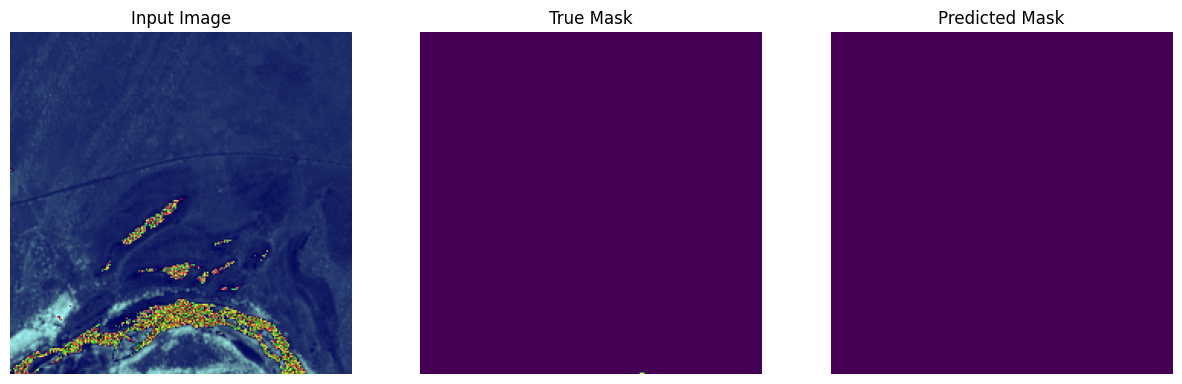

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
['C:\\Users\\91962\\Desktop\\zinditiled/labels_test/tile_2017-07-10_1018.png']
[0 1 4 5 6 7 8 9]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


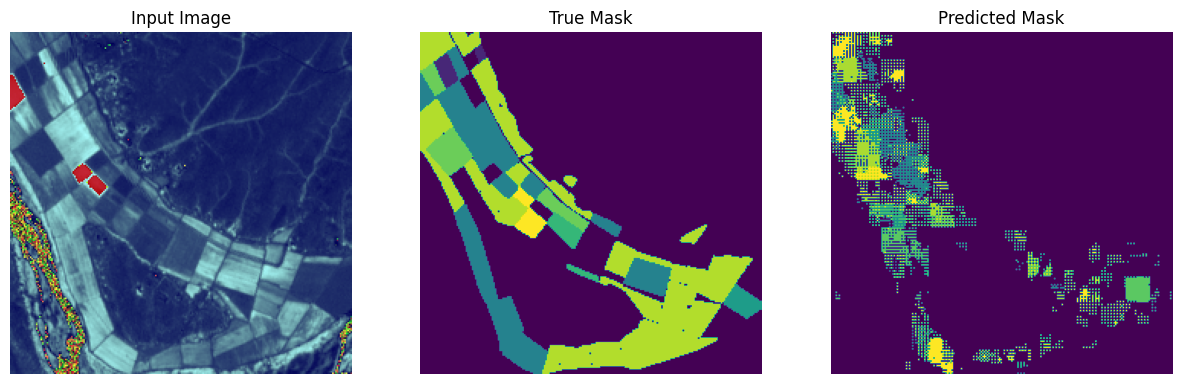

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
['C:\\Users\\91962\\Desktop\\zinditiled/labels_test/tile_2017-07-10_1019.png']
[0 4 8]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


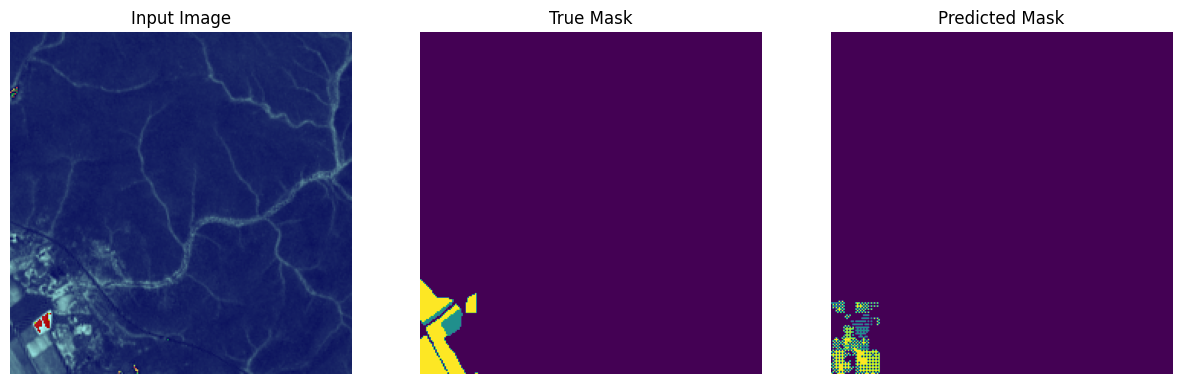

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
['C:\\Users\\91962\\Desktop\\zinditiled/labels_test/tile_2017-07-10_1068.png']
[0 4 5 6 8 9]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


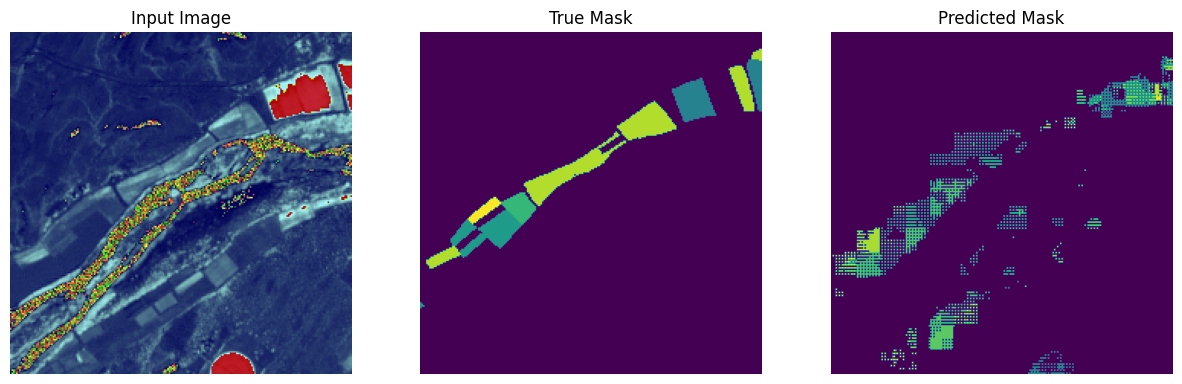

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
['C:\\Users\\91962\\Desktop\\zinditiled/labels_test/tile_2017-07-10_1118.png']
[0 1 2 4 7 8 9]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


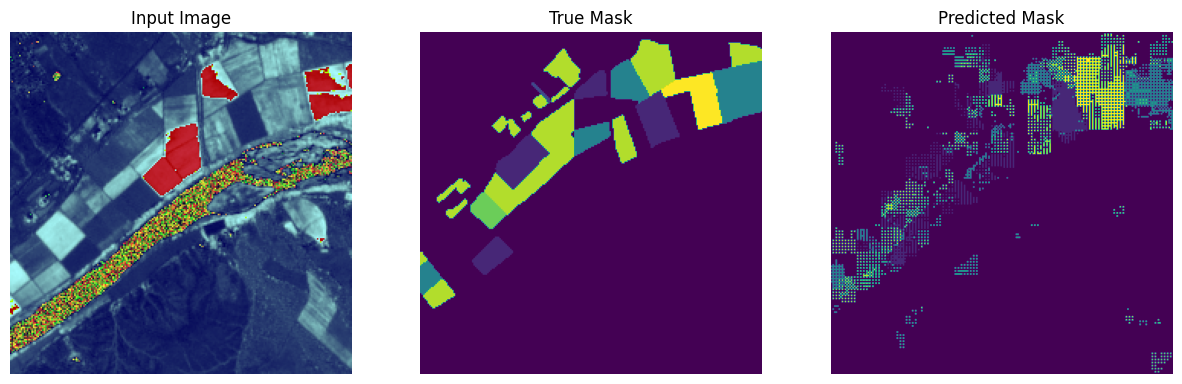

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
['C:\\Users\\91962\\Desktop\\zinditiled/labels_test/tile_2017-07-10_1167.png']
[0 1 4 8 9]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


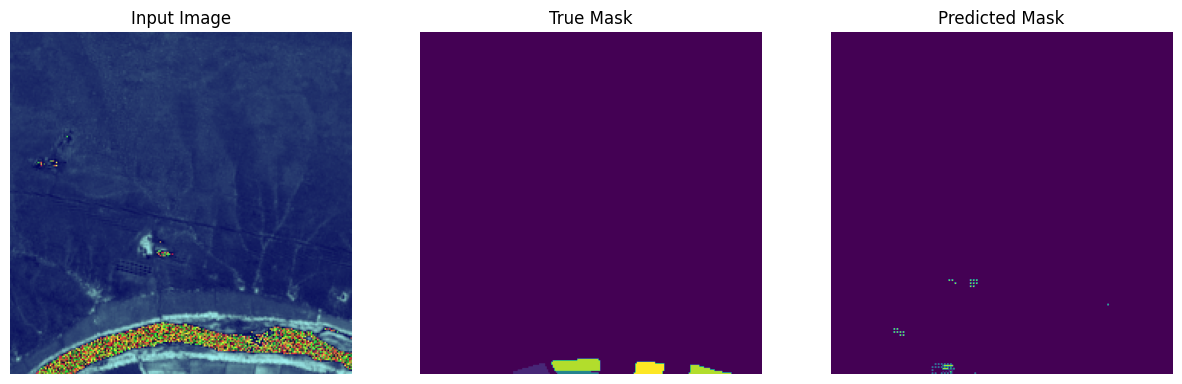

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
['C:\\Users\\91962\\Desktop\\zinditiled/labels_test/tile_2017-07-10_1168.png']
[0 1 4 5 6 7 8 9]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


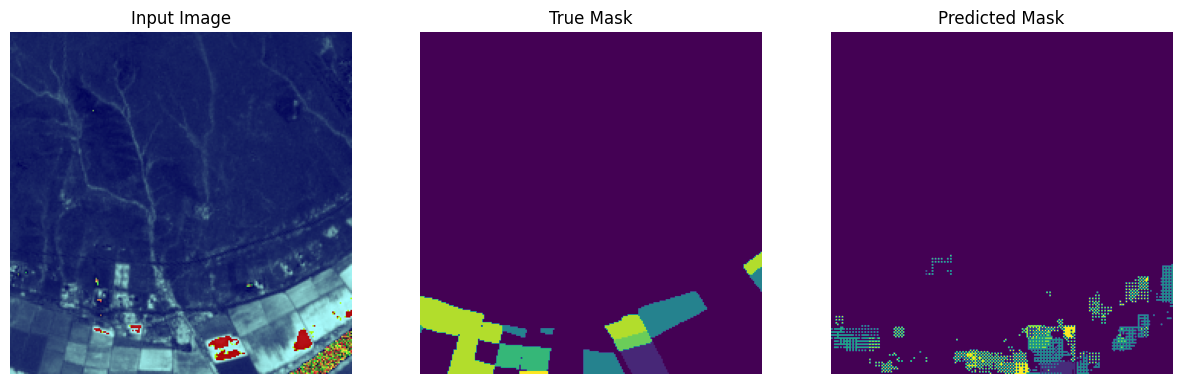

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
['C:\\Users\\91962\\Desktop\\zinditiled/labels_test/tile_2017-07-10_1218.png']
[0 1 4 5 8]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


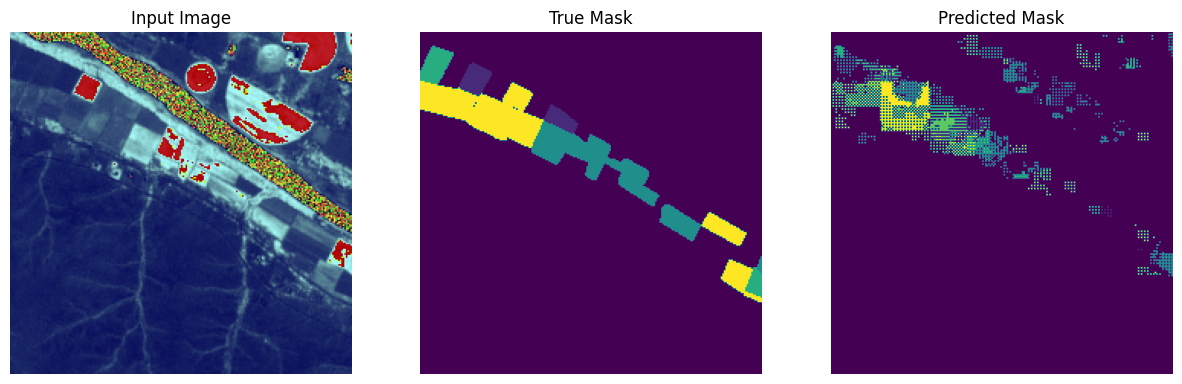

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
['C:\\Users\\91962\\Desktop\\zinditiled/labels_test/tile_2017-07-10_1268.png']
[0 1 2 4 5 8]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


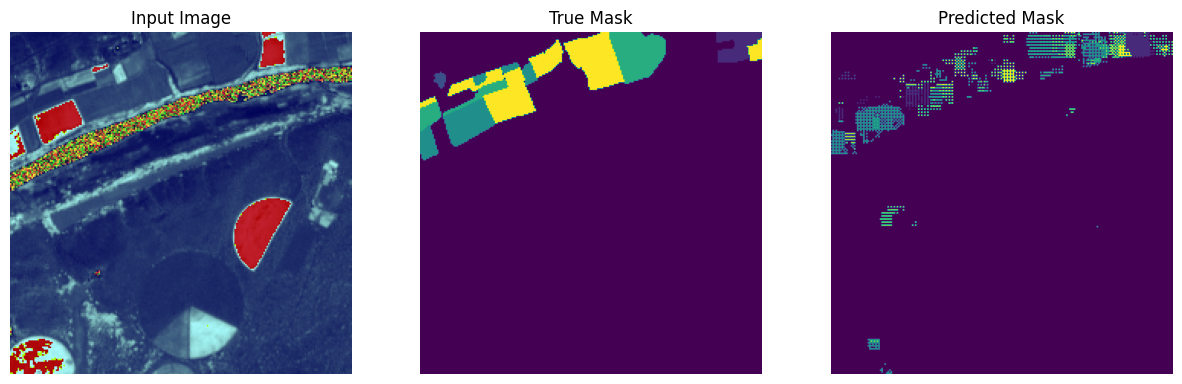

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
['C:\\Users\\91962\\Desktop\\zinditiled/labels_test/tile_2017-07-10_1269.png']
[0 1 3 4 5 8]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


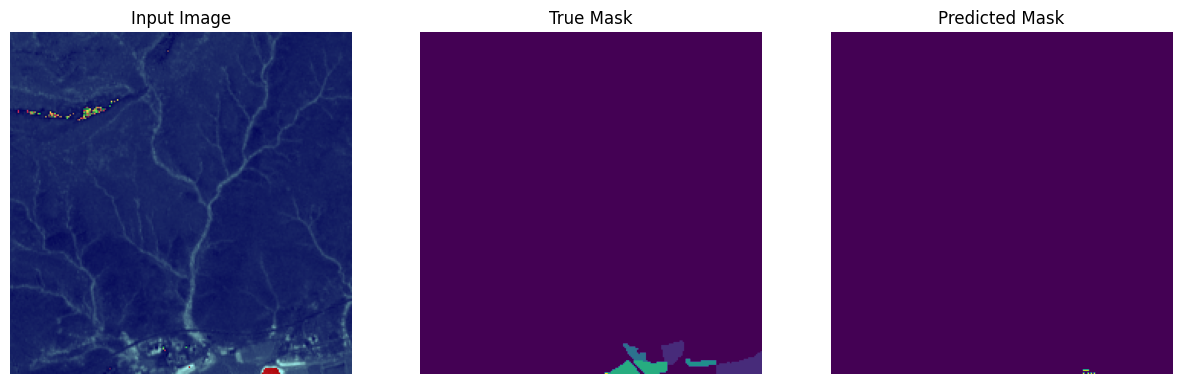

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
['C:\\Users\\91962\\Desktop\\zinditiled/labels_test/tile_2017-07-10_1318.png']
[0 1 4 8]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


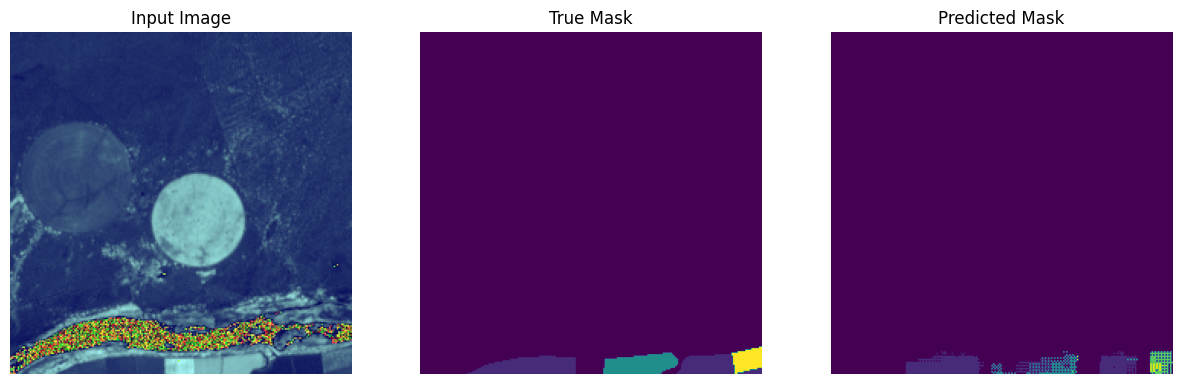

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
['C:\\Users\\91962\\Desktop\\zinditiled/labels_test/tile_2017-07-10_1319.png']
[0 1 4 5 7 8]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


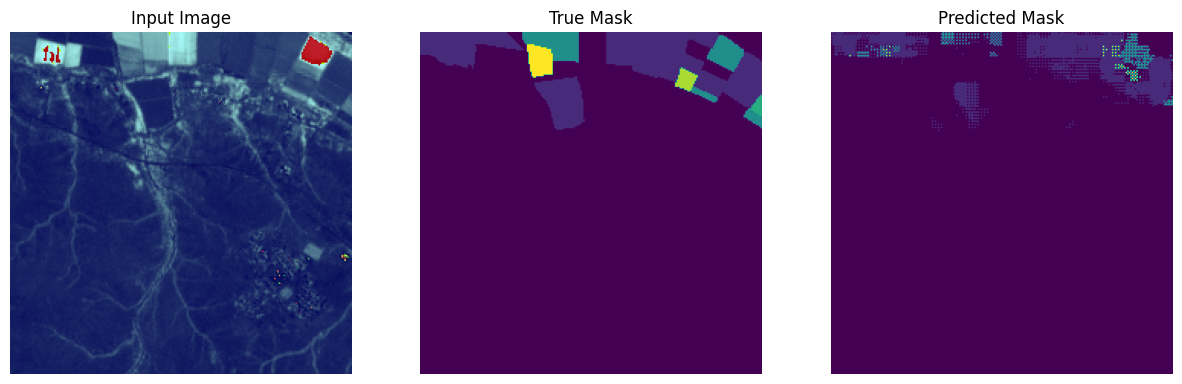

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
['C:\\Users\\91962\\Desktop\\zinditiled/labels_test/tile_2017-07-10_1369.png']
[0 1 2 4 5 7 8]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


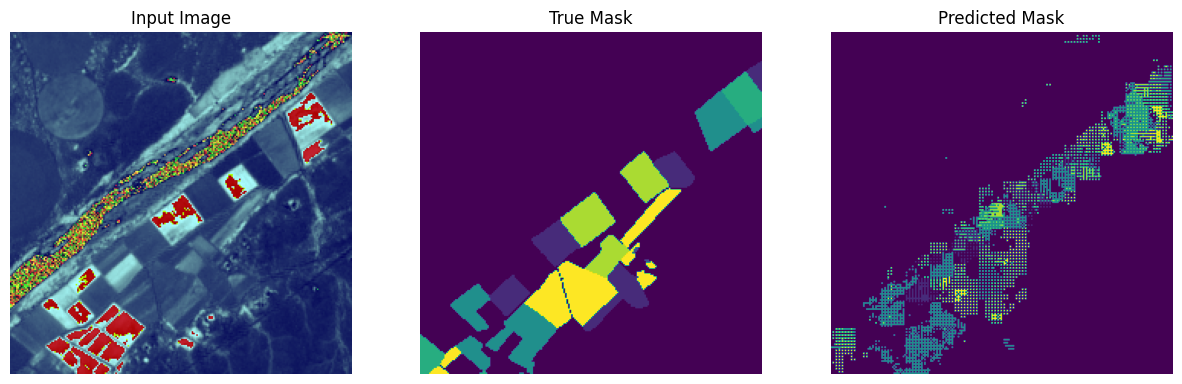

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
['C:\\Users\\91962\\Desktop\\zinditiled/labels_test/tile_2017-07-10_1370.png']
[0 4 5 8]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


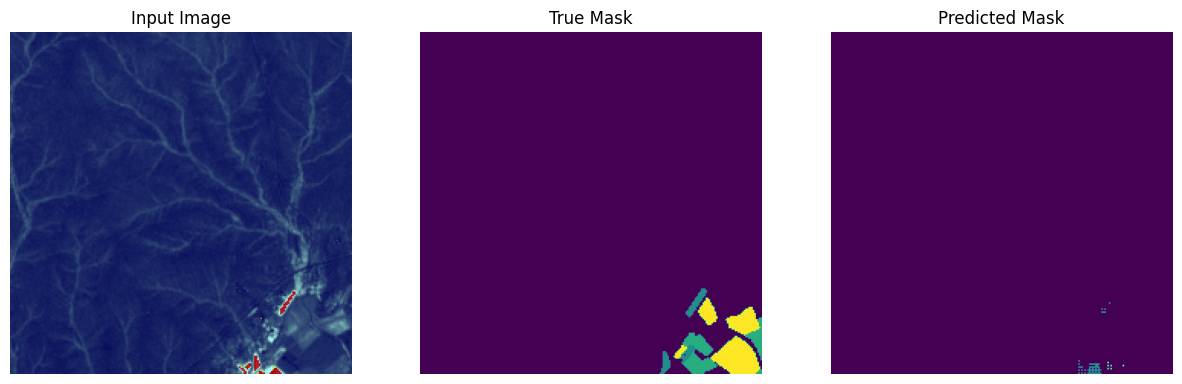

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
['C:\\Users\\91962\\Desktop\\zinditiled/labels_test/tile_2017-07-10_1419.png']
[0 5]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


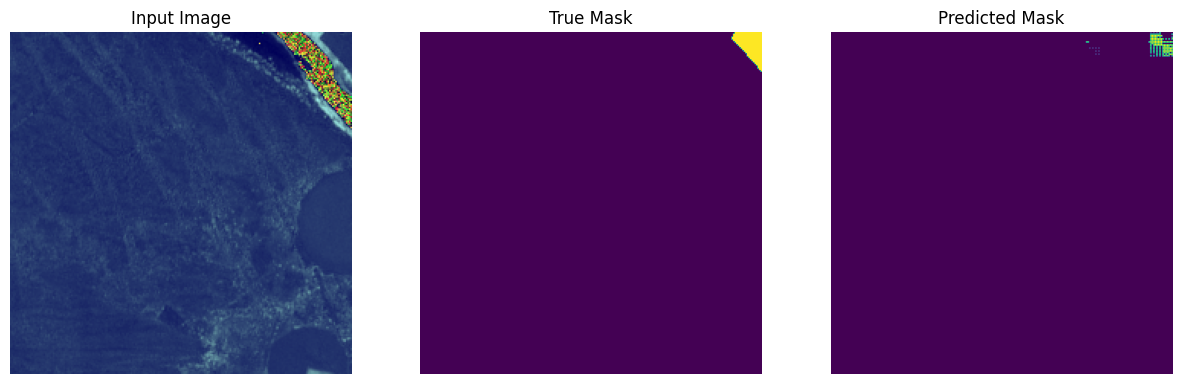

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
['C:\\Users\\91962\\Desktop\\zinditiled/labels_test/tile_2017-07-10_1420.png']
[0 4 5 7 8]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


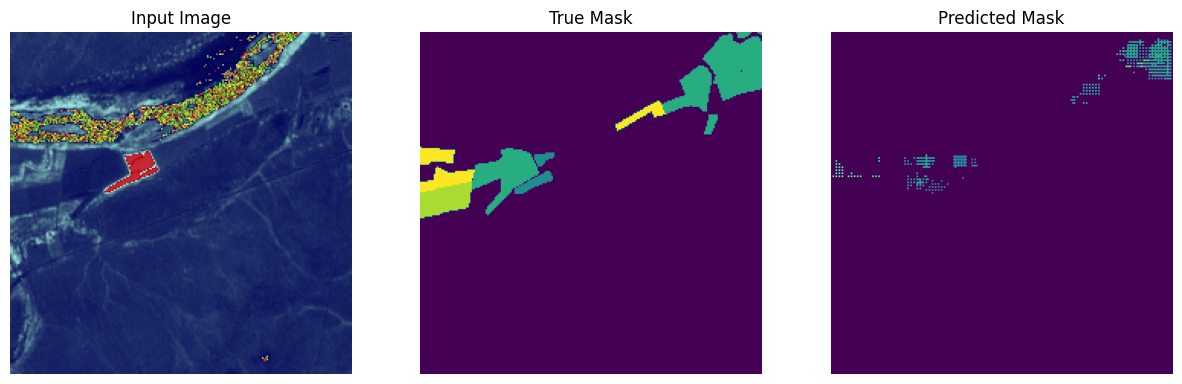

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
['C:\\Users\\91962\\Desktop\\zinditiled/labels_test/tile_2017-07-10_1470.png']
[0 4 5 7 8 9]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


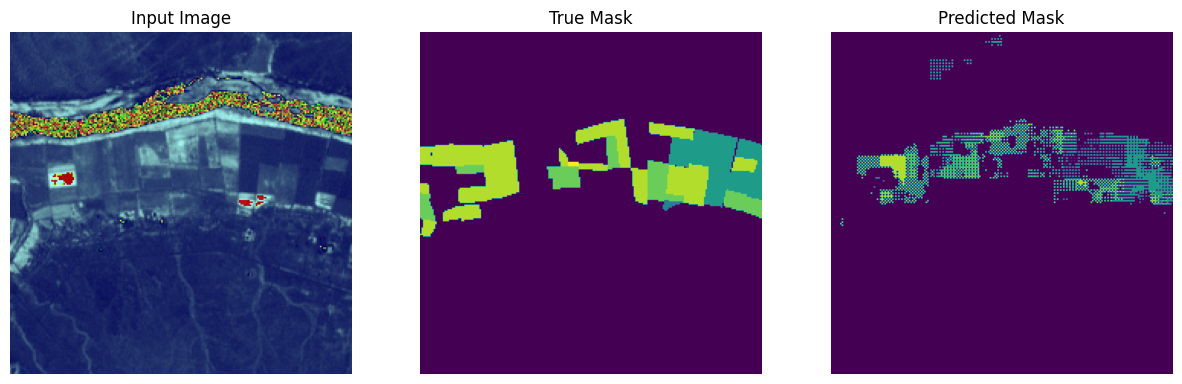

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
['C:\\Users\\91962\\Desktop\\zinditiled/labels_test/tile_2017-07-10_1520.png']
[0 4 5 7 8]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


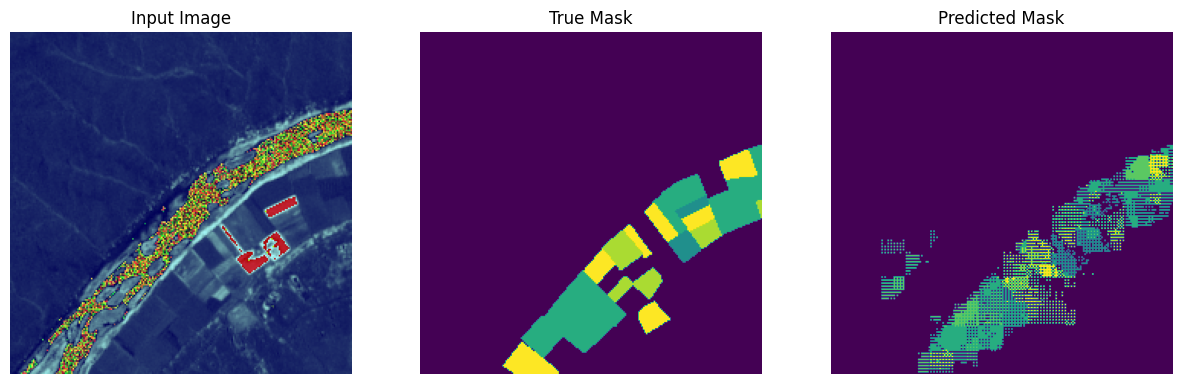

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
['C:\\Users\\91962\\Desktop\\zinditiled/labels_test/tile_2017-07-10_1521.png']
[0 5 8]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


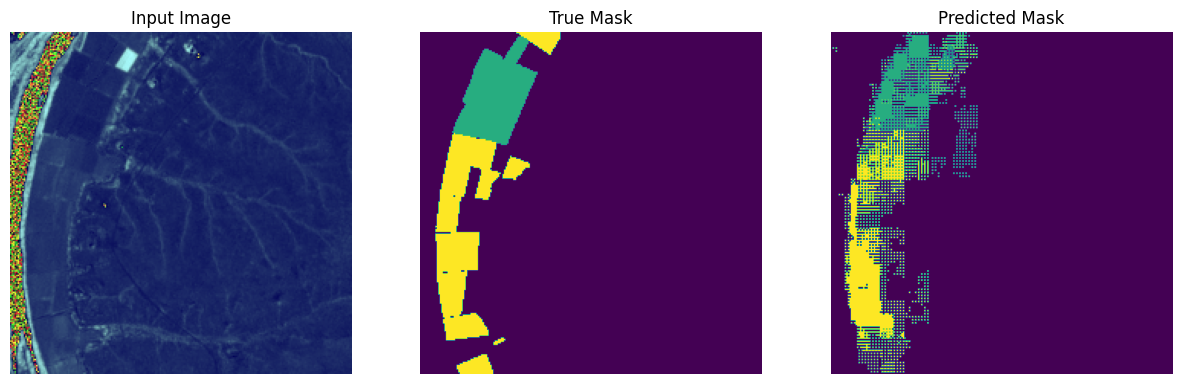

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
['C:\\Users\\91962\\Desktop\\zinditiled/labels_test/tile_2017-07-10_1522.png']
[0 1 4 5 6 7 8]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


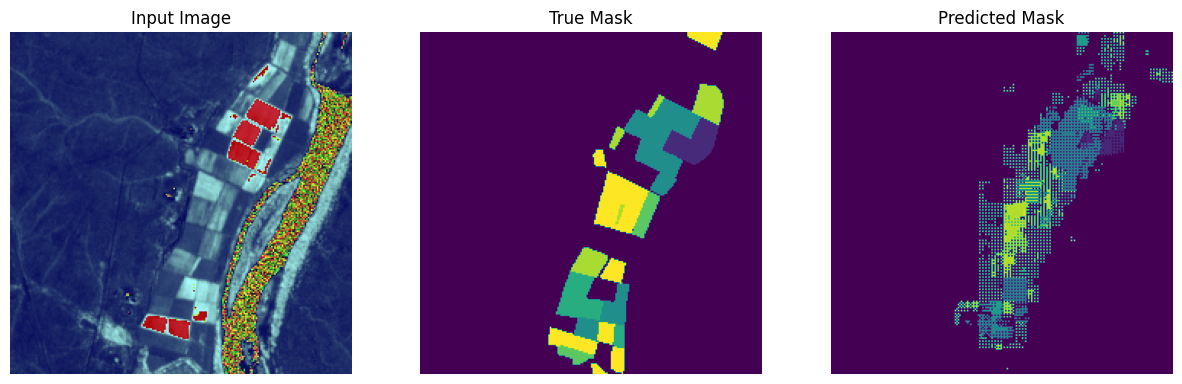

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


In [121]:
#Multi image example
tiled_prediction_dir = os.path.join(personal_dir,'predictions_test/')
if not os.path.exists(tiled_prediction_dir):
    os.makedirs(tiled_prediction_dir)
    
pred_masks = []
true_masks = []

for i in range(0, 20):
    img_num = i

    temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1], 
                                   foreground_list_y[img_num:img_num+1],
                                   preproc_fn=tr_preprocessing_fn,
                                   batch_size=1,
                                   shuffle=False)

    # Let's examine some of these augmented images

    iterator = iter(temp_ds)
    next_element = iterator.get_next()

    batch_of_imgs, label = next_element

    # Running next element in our graph will produce a batch of images

    sample_image, sample_mask = batch_of_imgs[0], label[0,:,:,:]
    sample_mask_int = tf.dtypes.cast(sample_mask, tf.int32)
    true_masks.append(sample_mask_int)
    print(foreground_list_y[img_num:img_num+1])
    print(np.unique(sample_mask_int))

    # run and plot predicitions

    show_predictions()
    pred_mask = get_predictions()
    pred_masks.append(pred_mask)
    
    # save prediction images to file

    filename_split = os.path.splitext(foreground_list_x[img_num]) 
    filename_zero, fileext = filename_split 
    basename = os.path.basename(filename_zero) 
    tf.keras.preprocessing.image.save_img(tiled_prediction_dir+'/'+basename+".png",pred_mask)

In [122]:
# flatten our tensors and use scikit-learn to create a confusion matrix
flat_preds = tf.reshape(pred_masks, [-1]) 
flat_truth = tf.reshape(true_masks, [-1]) 
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))

In [123]:
# check values in predicted masks vs truth masks
check_preds = tf.keras.backend.eval(flat_preds)
check_truths = tf.keras.backend.eval(flat_truth)
print(np.unique(check_preds), np.unique(check_truths))

[0 1 2 3 4 5 6 7 8 9] [0 1 2 3 4 5 6 7 8 9]


In [124]:
class_names

array(['Cotton', 'Dates', 'Grass', 'Lucern', 'Maize', 'Pecan', 'Vacant',
       'Vineyard', 'Vineyard & Pecan ("Intercrop")'], dtype=object)

(9.5, -0.5)

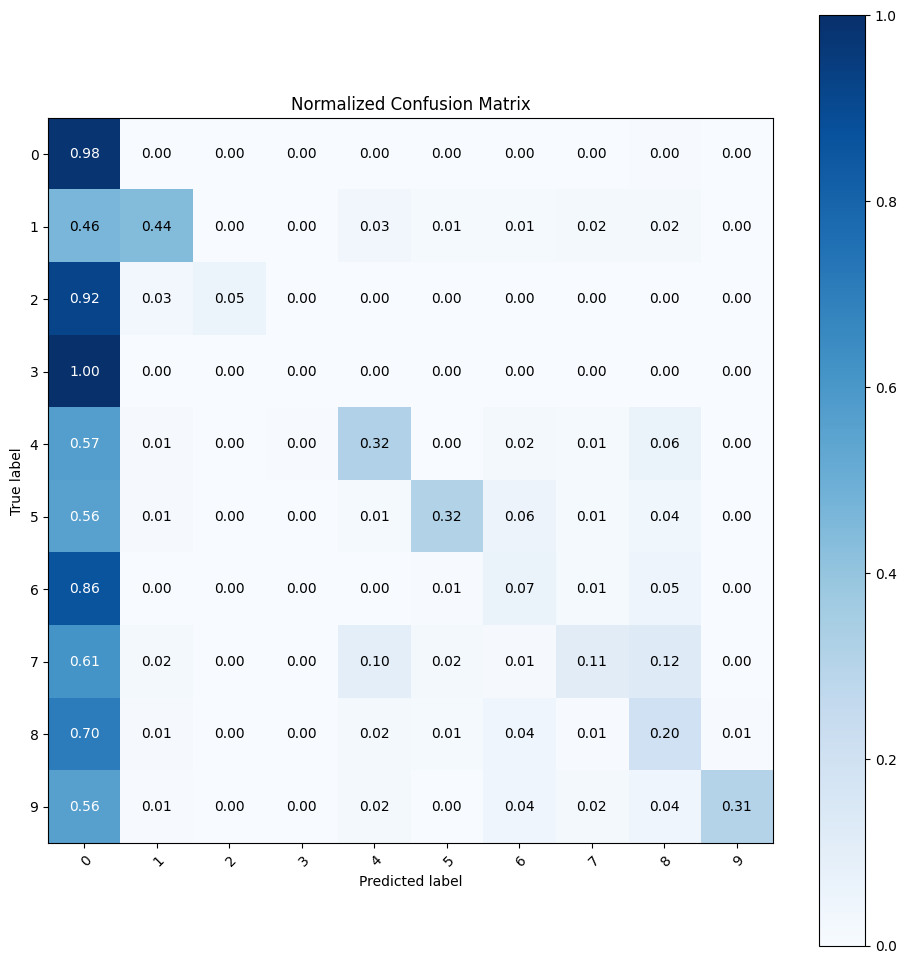

In [127]:
classes = [0,1,2,3,4,5,6,7,8,9]

%matplotlib inline
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=list(range(OUTPUT_CHANNELS)), yticklabels=list(range(OUTPUT_CHANNELS)),
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' #'d' # if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)
ax.set_ylim(len(classes)-0.5, -0.5)

In [128]:

f1_score(flat_truth, flat_preds, average='macro')

0.3230119814688341

SyntaxError: invalid syntax (1271993541.py, line 1)

In [134]:
import rasterio
# Open a dataset
with rasterio.open(r"C:\Users\91962\Desktop\zindi\2017-01-01-JFP\S2A_MSIL1C_20170101T082332_N0204_R121_T34JFP_20170101T084543.SAFE\GRANULE\L1C_T34JFP_A007983_20170101T084543\IMG_DATA\T34JFP_20170101T082332_B03.jp2") as src:
    # Read raster data as array
    raster_data = src.read()
    meta = src.meta
    print("Shape of raster data array:", raster_data.shape)
print("Metadata:", meta)

Shape of raster data array: (1, 10980, 10980)
Metadata: {'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32734), 'transform': Affine(10.0, 0.0, 600000.0,
       0.0, -10.0, 6900040.0)}
